### 한국어 Word2Vec 실습
gensim 패키지에서 제공하는 이미 구현된 Word2Vec을 사용하여 한국어 데이터를 학습합니다. <br>
한국어 Word2Vec 만들기(네이버 영화 리뷰)
네이버 영화 리뷰 데이터로 한국어 Word2Vec을 만들어봅시다.

knolpy 설치

In [2]:
!apt-get update
!apt-get install g++ openjdk-8-jdk
!pip install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [662 kB]
Get:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,621 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [50.4 kB]
Get:13 http://arch

In [3]:
from konlpy.tag import Okt
tokenizer = Okt()

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

네이버 영화 리뷰 데이터를 다운로드합니다.

In [5]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x78926b001840>)

네이버 영화 리뷰 데이터를 데이터프레임으로 로드하고 상위 5개의 행을 출력해봅시다.

In [6]:
train_data = pd.read_table('ratings.txt')

In [7]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


총 리뷰 개수를 확인해보겠습니다.

In [8]:
print(len(train_data)) # 리뷰 개수 출력

200000


총 20만개의 샘플이 존재하는데, 결측값 유무를 확인합니다.

In [9]:
# NULL 값 존재 유무
print(train_data.isnull().values.any())

True


결측값이 존재하므로 결측값이 존재하는 행을 제거합니다.

In [10]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


결측값이 삭제된 후의 리뷰 개수를 확인합니다.

In [11]:
print(len(train_data)) # 리뷰 개수 출력

199992


총 199,992개의 리뷰가 존재합니다. 정규 표현식을 통해 한글이 아닌 경우 제거하는 전처리를 진행합니다.

In [12]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

<ipython-input-12-d10eedfa8951>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [13]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


학습 시에 사용하고 싶지 않은 단어들인 불용어를 제거하겠습니다. 형태소 분석기 Okt를 사용하여 각 문장에 대해서 일종의 단어 내지는 형태소 단위로 나누는 토큰화를 수행합니다. 다소 시간이 소요될 수 있습니다.

In [15]:
from tqdm import tqdm

In [16]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()

tokenized_data = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

100%|██████████| 199992/199992 [13:54<00:00, 239.66it/s]


토큰화가 된 상태에서는 각 리뷰의 길이 분포 또한 확인이 가능합니다.

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


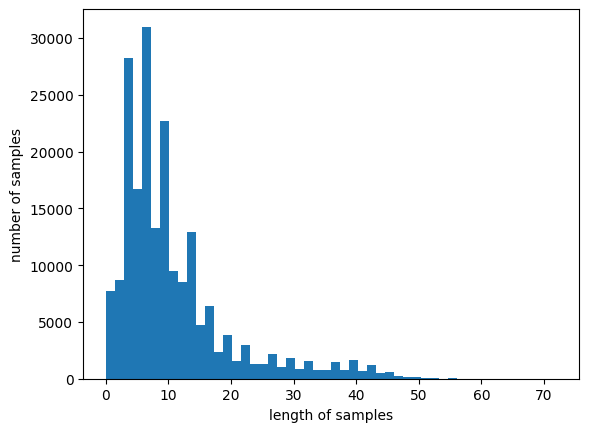

In [31]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

Word2Vec으로 토큰화 된 네이버 영화 리뷰 데이터를 학습합니다.

In [17]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

학습이 다 되었다면 Word2Vec 임베딩 행렬의 크기를 확인합니다.

In [18]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(16477, 100)

총 16,477개의 단어가 존재하며 각 단어는 100차원으로 구성되어져 있습니다. '최민식'과 유사한 단어들을 뽑아봅시다.

In [19]:
print(model.wv.most_similar("최민식"))

[('한석규', 0.8727660179138184), ('김수현', 0.851405143737793), ('윤제문', 0.841753363609314), ('엄태웅', 0.837470531463623), ('김갑수', 0.8365069031715393), ('이민호', 0.8357429504394531), ('안성기', 0.8322241306304932), ('서영희', 0.8288522362709045), ('김창완', 0.828521728515625), ('중견', 0.8259392976760864)]


In [20]:
print(model.wv.most_similar("히어로"))

[('느와르', 0.8558932542800903), ('슬래셔', 0.8542499542236328), ('무협', 0.8302155137062073), ('물의', 0.8244690299034119), ('호러', 0.8184893727302551), ('무비', 0.8144285082817078), ('정통', 0.8017527461051941), ('최고봉', 0.8016433715820312), ('로코', 0.7923560738563538), ('물', 0.7913175225257874)]


In [23]:
print(model.wv.most_similar("괴물"))

[('외계인', 0.8043042421340942), ('악당', 0.7405251860618591), ('경찰', 0.7073683142662048), ('상어', 0.6917855739593506), ('로봇', 0.671303927898407), ('귀신', 0.6662299633026123), ('인형', 0.6441306471824646), ('범인', 0.6387336254119873), ('칼', 0.6377255916595459), ('살인마', 0.6360295414924622)]


In [24]:
print(model.wv.most_similar("미야자키"))

[('하얗다', 0.8680709004402161), ('박찬욱', 0.8283584713935852), ('봉준호', 0.8175957798957825), ('류승완', 0.8123992085456848), ('마모루', 0.8095556497573853), ('스콧', 0.8050020337104797), ('크리스토퍼', 0.8038055896759033), ('핀처', 0.8035882711410522), ('왕가위', 0.8014329671859741), ('임권택', 0.7951405048370361)]


In [29]:
print(model.wv.most_similar("디즈니"))

[('픽사', 0.8685357570648193), ('드림웍스', 0.769116997718811), ('헐리웃', 0.7501369118690491), ('지브리', 0.7428427338600159), ('메이드', 0.7278355956077576), ('고전', 0.72568678855896), ('웰', 0.7111958861351013), ('애니매이션', 0.7110080718994141), ('국산', 0.7104979157447815), ('사극', 0.7051750421524048)]


In [30]:
print(model.wv.most_similar("엔딩"))

[('마지막', 0.689099133014679), ('크레딧', 0.6832347512245178), ('엔딩크레딧', 0.6688681840896606), ('곡', 0.648225724697113), ('해피엔딩', 0.6452752351760864), ('마무리', 0.6317214369773865), ('오프닝', 0.6300749182701111), ('앤딩', 0.6270884871482849), ('결말', 0.6187122464179993), ('씬', 0.6137628555297852)]
